Goal: do cross-validation with standard machine learning techniques (i.e. those that Alex tried)

In [1]:
library(dplyr)
library(caret)
library(e1071)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: lattice
Loading required package: ggplot2



Attaching package: ‘ranger’

The following object is masked from ‘package:randomForest’:

    importance



In [23]:
source("utils.R")
path  = "/master/rault/TB"
data_path = paste(path, "/data", sep="")
conda.r = "/master/rault/miniconda3/lib/R/library"

In [18]:
#library(devtools)
#with_libpaths(new = conda.r, install_github('topepo/caret/pkg/caret'))
#install.packages("caret", conda.r)

#install.packages("deepnet", conda.r)
#devtools::install_github('topepo/caret/pkg/caret')
#install.packages("ranger", conda.r)
#install.packages("glmnet", conda.r)
#install.packages("gbm", conda.r)
#install.packages("e1071", conda.r)
#install.packages("mlbench", conda.r)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [3]:
pheno = read.table(file=paste(data_path, "Monkey_PhenoData_middle-late.txt", sep="/"), header=T, sep="\t")
expres =  read.table(file=paste(data_path, "Monkey_Processed_ExpressionData_middle-late.txt", sep="/"), header=T, sep="\t")

Split into training and test sets, using the same random split used in python in initial neural networks training. It is 5 active TB monkeys and 6 latent TB monkeys, a roughly 70-30% train-test split.

In [5]:
test.latent.monkeys = c('M13', 'M27', 'M34', 'M15', 'M35', 'M36')
test.active.monkeys = c('M1', 'M16', 'M32', 'M18', 'M23')

In [6]:
# THis is correct, 48 samples as in the python code
dim(filter(pheno, monkeyid %in% union(test.latent.monkeys, test.active.monkeys)))

[1] 84 13

In [7]:
#head(rownames(pheno))
#identical(rownames(pheno), rownames(expres)) # TRUE
#train.pheno = rownames(pheno[pheno$monkeyid %in% union(test.latent.monkeys, test.active.monkeys),])

test.rows = rownames(pheno[pheno$monkeyid %in% union(test.latent.monkeys, test.active.monkeys),])
train.rows = setdiff(rownames(pheno), test.rows)

pheno.train = droplevels(pheno[train.rows,])
pheno.test = droplevels(pheno[test.rows,])
expres.train = droplevels(expres[train.rows,])
expres.test = droplevels(expres[test.rows,])

Going to need to figure out grouped cross-validation according to Monkey, as we did before.

Great code for comparing models:
https://machinelearningmastery.com/compare-models-and-select-the-best-using-the-caret-r-package/

Improving machine learning model performance
https://machinelearningmastery.com/machine-learning-performance-improvement-cheat-sheet/

In depth tuning of random forests in R
https://machinelearningmastery.com/tune-machine-learning-algorithms-in-r/

I think I'll do 10-fold cross-validation with 3 repeats as he does
control <- trainControl(method="repeatedcv", number=10, repeats=3)
My metric will be accuracy I think. That's what I want.

The caret package documentation is pretty good:
https://topepo.github.io/caret/model-training-and-tuning.html#control

In [8]:
set.seed(100)
folds = groupKFold(pheno.train$monkeyid, k=10)

Sometimes this function gives 1 fewer folds, as it did in my test of the different techniques.

In [49]:
folds.2 =  groupKFold(pheno.train$monkeyid, k=10)
print(length(folds.2))

[1] 10


In [9]:
for (fold in lapply(folds, function(x) {pheno.train$monkeyid[x]}))
    print(length((as.character(fold))))

#folds = groupKFold(pheno.train$monkeyid, k=10)
lapply(folds, function(x, y) table(y[x]), y = pheno.train$monkeyid)
       
       # this should roughly work
       # Else the website below may help me:
      # https://stackoverflow.com/questions/48142617/caret-combine-createresample-and-groupkfold?rq=1

[1] 202
[1] 194
[1] 186
[1] 174
[1] 187
[1] 179
[1] 186
[1] 178
[1] 194


$Fold1

M10 M11 M12 M14 M17 M19  M2 M20 M21 M22 M24 M25 M26 M28 M29  M3 M30 M31 M33 M37 
  5   8   8   0   8   7   8   8   8   8   8   8   8   8   8   8   8   7   8   8 
M38  M4  M5  M6  M7  M8  M9 
  7   8   8   8   8   8   8 

$Fold2

M10 M11 M12 M14 M17 M19  M2 M20 M21 M22 M24 M25 M26 M28 M29  M3 M30 M31 M33 M37 
  5   8   8   8   8   7   8   8   8   0   8   8   8   8   8   8   8   7   8   8 
M38  M4  M5  M6  M7  M8  M9 
  7   8   8   8   8   0   8 

$Fold3

M10 M11 M12 M14 M17 M19  M2 M20 M21 M22 M24 M25 M26 M28 M29  M3 M30 M31 M33 M37 
  5   0   8   8   8   7   8   8   8   8   8   8   0   8   8   8   0   7   8   8 
M38  M4  M5  M6  M7  M8  M9 
  7   8   8   8   8   8   8 

$Fold4

M10 M11 M12 M14 M17 M19  M2 M20 M21 M22 M24 M25 M26 M28 M29  M3 M30 M31 M33 M37 
  0   8   8   8   8   7   8   0   8   8   8   8   8   0   8   8   8   0   0   8 
M38  M4  M5  M6  M7  M8  M9 
  7   8   8   8   8   8   8 

$Fold5

M10 M11 M12 M14 M17 M19  M2 M20 M21 M22 M24 M25 M26 M28 M29  M3 M30 M31 M33 

In [10]:
print(dim(pheno.train))
print(dim(pheno.test))
print(dim(pheno))

[1] 210  13
[1] 84 13
[1] 294  13


In [11]:
expres.train$time.period = pheno.train$time.period

In [83]:
install.pac # I need to make sure I use the proper destination folder, using that R and Jupyter post
library(e1071)

ERROR: Error in library(e1071): there is no package called ‘e1071’


In [ ]:
# This would be one example
#this k-folds thing is being VERY complicated
# I don't know how this code will go
# It was a lot simpler in python with the grouping variables for groupkfold

seed=100
control <- trainControl(method="cv", index=folds, search="random")
set.seed(seed)
mtry <- sqrt(ncol(expres.train))
rf_random <- train(time.period~., data=expres.train, method="rf", tuneLength=15, trControl=control)
print(rf_random)
plot(rf_random)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin



In [104]:
rf_random

Random Forest 

 210 samples
9050 predictors
   2 classes: 'late', 'middle' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 202, 194, 186, 174, 187, 179, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   511  0.6928882  0.3851703
  1541  0.6869892  0.3731999
  2332  0.6942697  0.3879481
  2538  0.6896400  0.3786888
  3352  0.6991731  0.3980741
  3607  0.6945435  0.3888149
  4241  0.6806546  0.3607680
  4379  0.6722789  0.3439666
  4947  0.7097018  0.4190047
  4999  0.6864416  0.3726112
  5657  0.6945435  0.3885458
  6055  0.6793852  0.3583565
  6902  0.7026453  0.4047495
  7353  0.7027573  0.4051158
  7984  0.6992851  0.3979311

Accuracy was used to select the optimal model using  the largest value.
The final value used for the model was mtry = 4947.

This website helps me make use of the multiple cores available to me:

https://github.com/lgreski/datasciencectacontent/blob/master/markdown/pml-randomForestPerformance.md

I should use multicore with caret code below to test different models

I may also need to use ranger implementation of randomforests, but I think with these tools I should be able to do the cross-validation relatively smoothly to find a good model with basic parameter tuning.

In [84]:
set.seed(131)
groups <- sort(sample(letters[1:4], size = 20, replace = TRUE))
table(groups)
folds <- groupKFold(groups)
lapply(folds, function(x, y) table(y[x]), y = groups)
       

groups
a b c d 
4 8 4 4 

$Fold1

b c d 
8 4 4 

$Fold2

a c d 
4 4 4 

$Fold3

a b d 
4 8 4 

$Fold4

a b c 
4 8 4 


Will need to consider adding preprocessing. Eventually feature selection, pathway calculation, etc. For now I am just trying the different algorithms

In [22]:
# Debugging the code
# NOW HERE i AM GOING TO TEST USING MULTIPLE CORES

#library(parallel)
#library(doParallel)

start_time <- Sys.time()

cluster = makeCluster(detectCores()-3) # Leaving 3 for other jobs
registerDoParallel(cluster)

seed=100
fit.control <- trainControl(method="cv", index=folds, search="random", allowParallel=TRUE)
set.seed(seed)
#mtry <- sqrt(ncol(expres.train))
rf_random.1 <- train(time.period~., data=expres.train, method="glmnet", tuneLength=5, trControl=fit.control)
stopCluster(cluster)
registerDoSEQ()

end_time <- Sys.time()
print(end_time - start_time)

Time difference of 29.20957 secs


It took 33.11227 seconds to run with detectCores - 3 parallelization (the new caret worked!
    -svmPoly 33.11227
    -glmnet 24.65823
    -glm taking forever! got warning "glm.fit algorithm di not converge - time difference 2.22 minutes
    -lda 3.396244 (variables are collinear)
    -dnn (a mini deep neural net library) 26.6911 secs

# Now without the parallel code
glmnet: 17.56562 seconds
try 5 tunelength
    -without: 42.71488 secs
    -with parallel: 29.20957

Now, how much without it?
$e^{i\pi} + 1 = 0$

In [32]:
alg="red"
bug ="blue"
l=list()
l[[alg]] = c(1,2,3)
#list((cat(alg)) = c(1,2,3))
l[[bug]] = c(2,3,4)
l

$red
[1] 1 2 3

$blue
[1] 2 3 4

In [ ]:
seed=7

# Now we are going to loop over different models
# This code does work as long as I have the appropriate packages downloaded.
start_time <- Sys.time()

cluster = makeCluster(detectCores()-2) # Leaving 3 for other jobs
registerDoParallel(cluster)

methods = c("gbm", "svmRadial", "svmPoly", "ranger", "glmnet", "dnn")
#LVQ model has bug with a small dataset, so I removed that technique

models = list()


#folds
control <- trainControl(method="cv", index=folds, search="random", allowParallel=TRUE)

for (alg in methods) {
    set.seed(seed)
    print("I have gotten to model:")
    print(alg)
    model = train(time.period~., data=expres.train, method=alg, tuneLength=15, trControl=control)
    models[[alg]] = model
}



save.progress(file="Monkey-TB-caret-15 length random grid")
stopCluster(cluster)
registerDoSEQ()

end_time <- Sys.time()
print(end_time - start_time)

In [35]:
models

$gbm
Stochastic Gradient Boosting 

 210 samples
9050 predictors
   2 classes: 'late', 'middle' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 202, 194, 186, 174, 187, 179, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.minobsinnode  n.trees  Accuracy   Kappa     
  0.1119008  10                 23               349     0.6908305  0.38167606
  0.1122428   1                 22               579     0.7296515  0.45860690
  0.1589682   6                  6              1989     0.5497323  0.08815429
  0.1924014   7                  9               424     0.7218857  0.44343657
  0.2281988   4                 25              1219     0.7049601  0.40809304
  0.2297839   7                  8              1158     0.5856741  0.16234782
  0.2626286  10                 13               482     0.6821978  0.36296185
  0.2746854  10                 20              2296     0.5906441  0.17525007
  0.2993476   3             


Call:
summary.resamples(object = results)

Models: gbm, svmRadial, svmPoly, ranger, glmnet, dnn 
Number of resamples: 9 

Accuracy 
           Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
gbm       0.625 0.6875000 0.7096774 0.7296515 0.8125000 0.8333333    0
svmRadial 0.625 0.6875000 0.7187500 0.7261793 0.7391304 0.8750000    0
svmPoly   0.625 0.6666667 0.6875000 0.7187370 0.7500000 0.8750000    0
ranger    0.625 0.6666667 0.7083333 0.7104734 0.7419355 0.8125000    0
glmnet    0.625 0.6875000 0.7083333 0.7169032 0.7500000 0.8125000    0
dnn       0.500 0.5000000 0.5000000 0.5072940 0.5161290 0.5277778    0

Kappa 
          Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
gbm       0.25 0.3750000 0.4166667 0.4586069 0.6250000 0.6666667    0
svmRadial 0.25 0.3750000 0.4375000 0.4518556 0.4772727 0.7500000    0
svmPoly   0.25 0.3333333 0.3750000 0.4375873 0.5000000 0.7500000    0
ranger    0.25 0.3333333 0.4166667 0.4203555 0.4833333 0.6250000    0
glmnet    0.

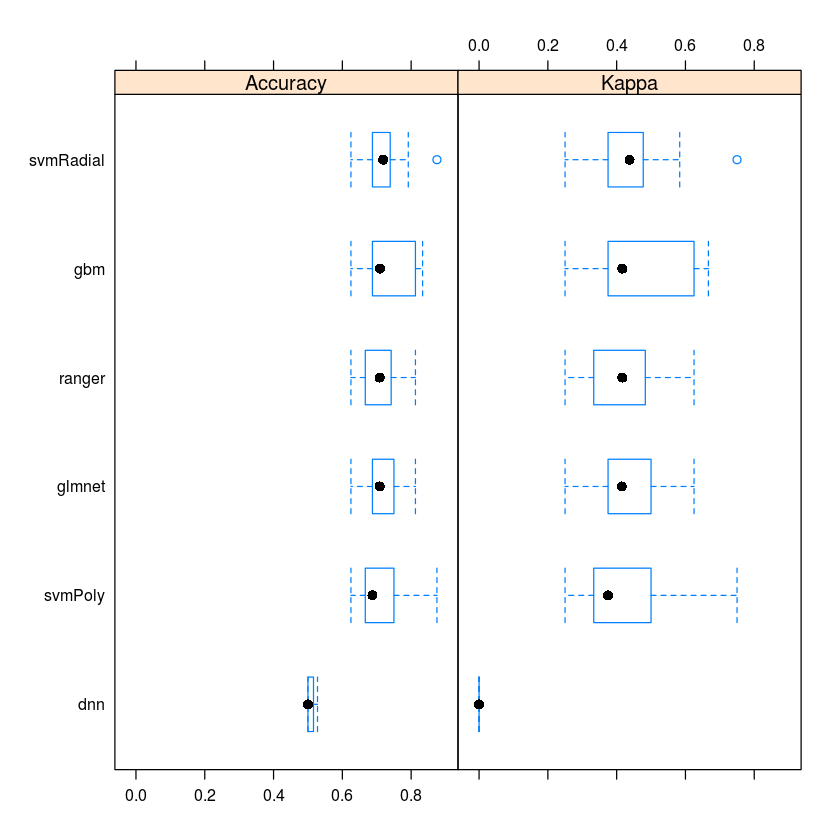

png 
  2

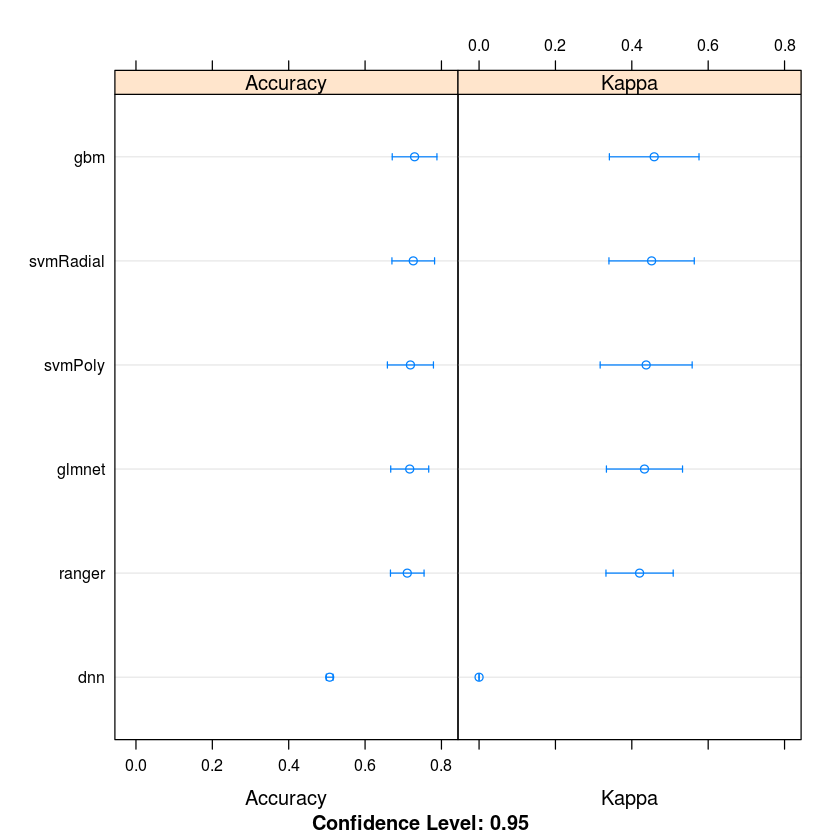

In [89]:
#load()
results = resamples(models)
summary(results)
bwplot(results)
dotplot(results)

pdf("Cross Validation-Parameter Search_5Feb2018.pdf")
bwplot(results)
dev.off()

### This explains how to do the predictions:
https://www.rdocumentation.org/packages/caret/versions/5.05.004/topics/predict.train

In [ ]:
extractPrediction(models,
                  testX = NULL, testY = NULL,
                  unkX = NULL, 
                  unkOnly = !is.null(unkX) & is.null(testX),
                  verbose = FALSE)

In [4]:
load("data/Monkey-TB-caret-15 length random grid-2018-02-01-.RData")

In [6]:
models$gbm

Stochastic Gradient Boosting 

 210 samples
9050 predictors
   2 classes: 'late', 'middle' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 202, 194, 186, 174, 187, 179, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.minobsinnode  n.trees  Accuracy   Kappa     
  0.1119008  10                 23               349     0.6908305  0.38167606
  0.1122428   1                 22               579     0.7296515  0.45860690
  0.1589682   6                  6              1989     0.5497323  0.08815429
  0.1924014   7                  9               424     0.7218857  0.44343657
  0.2281988   4                 25              1219     0.7049601  0.40809304
  0.2297839   7                  8              1158     0.5856741  0.16234782
  0.2626286  10                 13               482     0.6821978  0.36296185
  0.2746854  10                 20              2296     0.5906441  0.17525007
  0.2993476   3                 2

In [ ]:
library(caret)
model.gbm = models$gbm
#predBest = extractPrediction(model.gbm, testX=expres.test, testY = as.character(pheno.test$time.period))
pred.test = predict(model.gbm, newdata = expres.test)

In [15]:
confusionMatrix(pred.test, pheno.test$time.period, positive = "middle")

Confusion Matrix and Statistics

          Reference
Prediction late middle
    late     25      8
    middle   15     36
                                         
               Accuracy : 0.7262         
                 95% CI : (0.618, 0.8179)
    No Information Rate : 0.5238         
    P-Value [Acc > NIR] : 0.0001197      
                                         
                  Kappa : 0.4467         
 Mcnemar's Test P-Value : 0.2109029      
                                         
            Sensitivity : 0.8182         
            Specificity : 0.6250         
         Pos Pred Value : 0.7059         
         Neg Pred Value : 0.7576         
             Prevalence : 0.5238         
         Detection Rate : 0.4286         
   Detection Prevalence : 0.6071         
      Balanced Accuracy : 0.7216         
                                         
       'Positive' Class : middle         
                                         

In [13]:
?confusionMatrix


## Now I am going to add ratios of features (subtraction on the log scale)
## I will also center and scale the data in caret


In [1]:
3+3

[1] 6

In [ ]:
# This loop does work
n = 100
count = 0
for (i in rev(2:n)) {
    for (j in rev(1:(i-1))) {
        print(paste(i, j, sep=","))
        count = count + 1
    }
}
print(paste("Final count is:", count))
print("Expected count number")
print((n*(n-1)/2))

In [85]:
# Okay, I think this code is working now
create.ratios.log = function(x) {
    #print("Here is what create ratios sees")
    #print(x)
   # return(1)
    n = length(x)
    y = rep(0, n*(n-1)/2)
    #print(y)
    k = 1
    for (i in rev(2:n)) {
        for (j in rev(1:(i-1))) {
            y[k] = x[i] - x[j]
            k = k + 1
            #print(paste(i, j, sep=","))
            #count = count + 1
            }
        }
    #print("This is y")
    #print(y)
    return(y)
}

get.ratios = function(data) {
    data.ratio = apply(data, 1, create.ratios.log)
    data.ratio = cbind(data, t(data.ratio))
    return(data.ratio)
}

# Test case
w = data.frame(x=1:5, y =c(20, 1, 4, 5, 9), z=c(99, 2, 16, 21, 100), m=11:15)
#print(w)
z = get.ratios(w)
#print(z)

In [67]:
x = 1:6
n = length(x)
y = rep(0, n*(n-1)/2)
print(y)

 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [62]:
head(colnames(expres.train))


[1] "ILMN_2055271" "ILMN_1814092" "ILMN_2061446" "ILMN_3237396" "ILMN_1688755"
[6] "ILMN_1880387"

In [ ]:
expres.train.ratio = get.ratios(subset(expres.train, select=-c(time.period)))
#expres.test.ratio = get.ratios(subset(expres.test,select= -c(time.period)))

The above code to get ratios did not finish running. I didn't have enough memory. I'll probably need to do it in python and load it in or something. Or it may not be computationally tractable with the resources I have.

### Since it is n^2 features, I will try just glmnet first

In [31]:
library(mlbench)
library(caret)
# load the dataset
data(PimaIndiansDiabetes)
# prepare training scheme
control <- trainControl(method="repeatedcv", number=10, repeats=3)
# train the LVQ model
set.seed(7)
modelLvq <- train(diabetes~., data=PimaIndiansDiabetes, method="lvq", trControl=control)
# train the GBM model
set.seed(7)
modelGbm <- train(diabetes~., data=PimaIndiansDiabetes, method="gbm", trControl=control, verbose=FALSE)
# train the SVM model
set.seed(7)
modelSvm <- train(diabetes~., data=PimaIndiansDiabetes, method="svmRadial", trControl=control)
# collect resamples
results <- resamples(list(LVQ=modelLvq, GBM=modelGbm, SVM=modelSvm))
# summarize the distributions
summary(results)
# boxplots of results
bwplot(results)
# dot plots of results
dotplot(results)


[1] 11.4

In [32]:
library(doParallel) rCluster <- makePSOCKcluster(6) registerDoParallel(rCluster)
# parllel processing should be utilized effectively.

[1] 0.5789474

In [51]:
?trainControl

In [61]:
?groupKFold

In [ ]:
# testing out list appending